<a href="https://colab.research.google.com/github/lsellers11/Quantum/blob/main/esandnucinabox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: This function is deprecated. Please call randint(-100, 101 + 1) instead


The eigenvalues are:  [ 0.45745984+0.j  1.00498837+0.j -0.06831201+0.j -0.57087834+0.j
 -1.04661971+0.j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

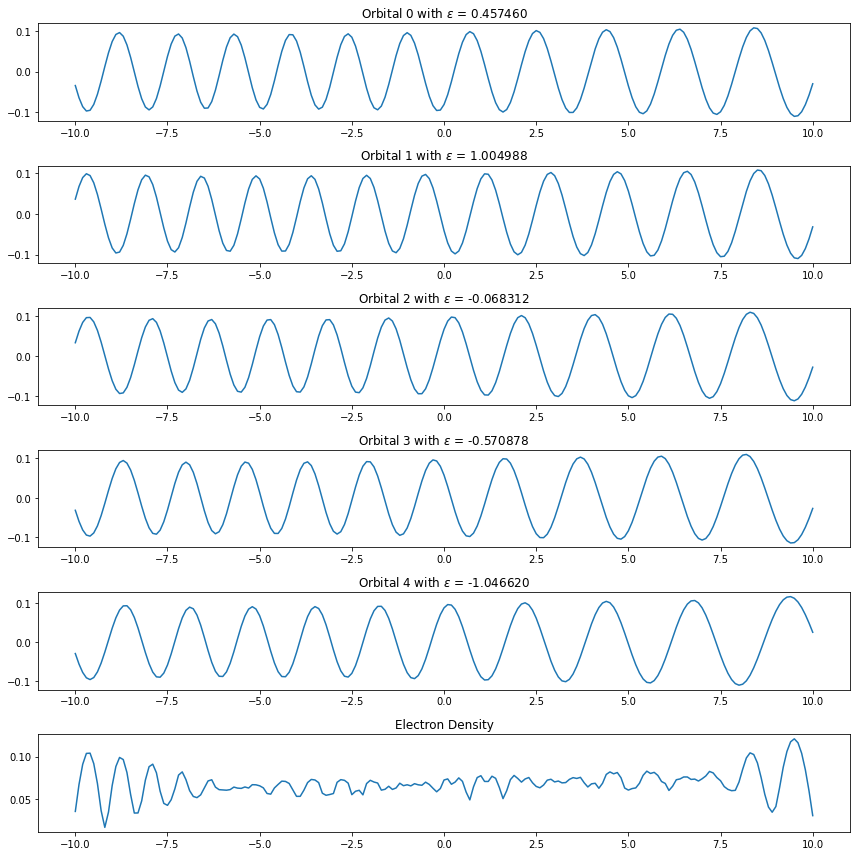

The nuclei coordinate(s) are:  [-6.8 -2.9  7. ]


In [ ]:
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
import numpy as np
from math import *
import cmath
import time
from tabulate import tabulate
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.special as scisp
import scipy.integrate as scint


### Paramters
L = 10;
N_ion = 3;
N_e = 5;
n = 200;
h = 2*L / n;
xgrid = -1*L*np.ones(n+1)+h*np.arange(n+1);

kappa = 0.1;
R = np.random.random_integers(-int(n/2),int(n/2)+1,N_ion)*h;
Z = 35;
rho = np.zeros(n+1);
phi = [];
f1 = 100;
f2 = [];
# for i in range(N_e):
#     b = np.sin((i+1)*pi*xgrid/(2*L));
#     b = b / np.linalg.norm(b);
#     phi.append(b);
#     f2.append(b);
#     rho += b**2;  
for i in range(N_e):
    b = scisp.eval_hermite(i, xgrid)*np.exp(-1*xgrid**2/2);
    b = b / np.linalg.norm(b);
    phi.append(b);
    f2.append(b);
    rho += b**2;
E_x = 0.0;
for i in range(N_e):
    for j in range(N_e):
        f = lambda y, x: sin(i*pi*y/(2*L))*sin(j*pi*y/(2*L))*sin(j*pi*x/(2*L))*sin(i*pi*x/(2*L))*kappa/2*exp(-kappa*abs(y-x));
        E_x += -1/2*scint.dblquad(f, -L, L, lambda x: -L, lambda x: L)[0];
alpha1 = 0.5;
alpha2 = 0.5;
count1 = 0;
count2 = 0;
maxit1 = 100;
maxit2 = 100;
e = np.ones(n+1);
epsilons = np.zeros(N_e);

while f1 >= 10**(-7) and count1 < maxit1:

    ### Update Orbitals phi
    if count1 > 0:
        E_x = E_xnew
        for i in range(N_e):
            phi[i] = alpha1*phi[i] + (1-alpha1)*psi[:,i];
    for i in range(N_e):
        phi[i] = phi[i] / np.linalg.norm(phi[i]);
    m = 0;
    while np.linalg.norm(f2[m:N_e]) >= 10**(-7) and count2 < maxit2:
        if count2 > 0:
            rho = alpha2*rho + (1-alpha2)*newrho;

        ### Kinetic Energy
        L = sp.spdiags(np.array([e/h**2, -2*e/h**2, e/h**2]), np.array([-1, 0, 1]), n+1, n+1, format = 'csr');
        H_L = -1/2*sp.csr_matrix.toarray(L);  

        ### External Potential due to Nuclei
        V_ion = np.zeros(n+1);
        H_ion = np.zeros((n+1, n+1));
        for i in range(N_ion):
            V_ion += -Z*(kappa/2)*np.exp(-kappa*abs(xgrid-R[i]*e));
            H_ion += np.diag(V_ion);
        if N_ion == 0:
            H_ion = np.zeros((n+1, n+1));

        ### Coulomb Potential
        A = sp.spdiags(np.array([-e/h**2, 2*e/h**2 + kappa**2*e, -e/h**2]), np.array([-1, 0, 1]), n+1, n+1, format = 'csr');
        f = -kappa**2*rho;
        V_c = spla.spsolve(A, f);
        H_c = np.diag(np.array(V_c));

        ### Exchange Potential
        H_x = np.zeros((n+1, n+1));
        for i in range(N_e):
            for j in range(n+1):
                l = 0;
                H_x[j, l:n+1] += -1*phi[i][j]*phi[i][l]*kappa/2*np.exp(-1*kappa*abs(xgrid[j]-xgrid[l])); 
        H = np.add(H_L, np.add(H_ion, np.add(H_c, H_x)));
        #H = H_L;
        epsilons, psi = spla.eigs(H, k = N_e, which = 'SM');
#         epsilons = np.array(epsilons);
#         psi = np.array(psi);

        ### Update Electron Density and Orbitals
        newrho = np.zeros(n+1);
        for i in range(N_e):
            psi[:,i] = psi[:,i] / np.linalg.norm(psi[:,i]);
            newrho += np.power(np.real(psi[:,i])**2 + np.imag(psi[:,i])**2, 0.5);
            f2.append(phi[i]-psi[:,i]);
        newrho = newrho / np.linalg.norm(newrho);
        count2 += 1;

    ### Update Exchange Energy
    E_xnew = 0;
    for i in range(N_e):
        E_xnew += np.dot(psi[:,i], np.dot(H_x, psi[:,i]));
    f1 = abs(E_xnew - E_x);
    count1 += 1;

print("The eigenvalues are: ", epsilons)

### Plot
if N_e == 1:
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1,2,1);
    ax.plot(xgrid, psi[:,0]);
    ax1 = fig.add_subplot(1,2,2);
    ax1.plot(xgrid, newrho);
    plt.show()
else:
    fig, ax = plt.subplots(N_e + 1, figsize=(12,12));
    plt.subplots_adjust(hspace = .6);
    for i in range(N_e):
        ax[i].plot(xgrid, psi[:,i], label = "Orbital %d with $\epsilon$ = %f"%(i, epsilons[i]));
        ax[i].title.set_text("Orbital %d with $\epsilon$ = %f"%(i, epsilons[i]))

    ax[N_e].plot(xgrid, newrho, label = 'e- Density');
    ax[N_e].title.set_text('Electron Density')
    fig.tight_layout()
    plt.show()
print("The nuclei coordinate(s) are: ", R)